In [1]:
import pandas as pd
import numpy as np
import os
import neo
from neo.io import AxonIO
from scipy.signal import butter, lfilter, freqz, savgol_filter
from scipy.stats import norm, pearsonr, expon, wilcoxon, gamma, spearmanr
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import matplotlib.image as mpimg
from matplotlib.cm import get_cmap
import pickle
import seaborn as sns

from utils import *
from lfpan import *
from loaders import StabilityDurationRecording, LFPRecording, StabilityRecording

plt.style.use('pcb')

In [2]:
tarr_universal = np.arange(-1,8,0.002)

names = [
    'reduced',
    'full'
]

dicts = []

for name in names:
    with open(f'data/generated/{name}.pkl', 'rb') as file:
        dicts.append(pickle.load(file))

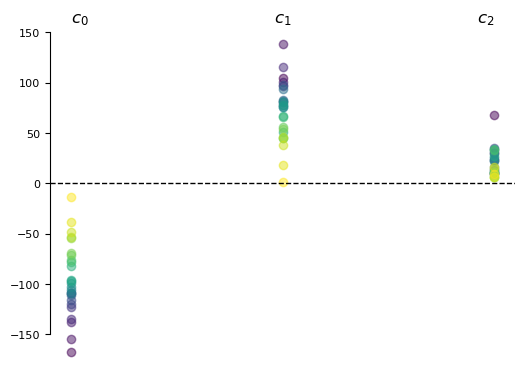

In [3]:
fig, ax = plt.subplots()

def plot_coefs(ax):
    cmap = get_cmap('viridis')
    coefs_all = pd.DataFrame(dicts[-1]['coefs_all']).sort_values(0).values
    colors = [cmap(x) for x in np.linspace(0,1,len(coefs_all))]

    for coefs, color in zip(coefs_all, colors):
        ax.plot(coefs, color=color, alpha=0.5, clip_on=False, marker='o', lw=0)
    
    ax.axhline(0, color='black', linestyle='dashed', lw=1)
    despine_ax(ax, where='b')
    ax.set_ylim(-150,150)
    ax.text(x=0, y=160, s=r'$c_0$', ha='left', fontdict={'family': 'stix', 'size': 12})
    ax.text(x=1, y=160, s=r'$c_1$', ha='center', fontdict={'family': 'cursive', 'size': 12})
    ax.text(x=2, y=160, s=r'$c_2$', ha='right', fontdict={'family': 'cursive', 'size': 12})
    
plot_coefs(ax)

In [8]:
def load_ix(ix, dur):
    kde = dicts[-1]['kdes_all'][ix][dur]
    varr = dicts[-1]['varrs_all'][ix][dur]
    pred = dicts[-1]['preds_all'][ix][dur]
    coefs = dicts[-1]['coefs_all'][ix]
    tarr_kde = np.linspace(2, 11, len(kde))
    tarr, filt = dicts[-1]['filts_all'][ix]
#     shapes = [1, 4, 2.5, 1.5]
#     taus = [1e-3, 13e-3, 35e-3, 0.5]
    shapes = [1, 1, 1]
    taus = [0e-3, 40e-3, 0.8]

    dt = tarr[1] - tarr[0]
    tarr2, filt2 = filter_from_coefs(coefs[:-1], taus[:-1], shapes[:-1], dt)
    
    filt_varrs = np.array([c*filter_expon(varr, tau, shape, dt)
                           for c, tau, shape in zip(coefs, taus, shapes)])
    
    trace_full = np.clip(filt_varrs.sum(axis=0), a_min=0, a_max=None)
    trace_med  = np.clip(filt_varrs[:-1].sum(axis=0), a_min=0, a_max=None)
    
    tarr_v = np.arange(len(trace_full))*(tarr[1]-tarr[0])
    
    return (resample(tarr_v, trace_full, tarr_univ),
            resample(tarr_v, trace_med, tarr_univ),
            resample(tarr_v, pred, tarr_univ),
            resample(tarr_kde, kde, tarr_univ),
            resample(tarr, filt, tarr_filt),
            resample(tarr, filt2, tarr_filt))

In [9]:
tarr_univ = np.arange(2, 11, 1e-3)
tarr_filt = np.arange(0, 5, 1e-3)

res = {}

for dur in [0.02, 0.2, 2]:
    traces_full = []
    traces_med = []
    kdes = []
    preds = []
    filts = []
    filts_med = []

    for ix in tqdm(range(26)):
        if ix == 8:
            continue
        trace_full, trace_med, pred, kde, filt, filt_med = load_ix(ix, dur)

        traces_full.append(np.clip(trace_full, a_min=0, a_max=None))
        traces_med.append(np.clip(trace_med, a_min=0, a_max=None))
        preds.append(np.clip(pred, a_min=0, a_max=None))
        kdes.append(kde)
        filts.append(filt)
        filts_med.append(filt_med)
        
    res[dur] = (traces_full, traces_med, kdes)

100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:15<00:00,  1.63it/s]


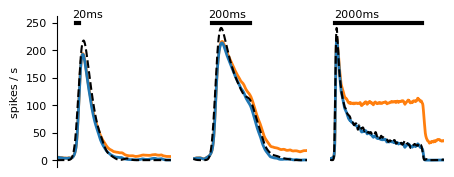

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(5,2))

def plot_preds(axes, colors=None, labels=None):
    if colors is None:
        colors = ['C0','C1']
    
    if labels is None:
        labels = ['full filter', 'reduced filter']
        
    xmaxs = [3.5, 3.5, 5.5]

    for ax, dur, xmax in zip(axes, [0.02, 0.2, 2], xmaxs):
        traces_full, traces_med, kdes = res[dur]

        ax.plot(tarr_univ, np.mean(traces_med, axis=0), lw=2, c=colors[1], label=labels[1])
        ax.plot(tarr_univ, np.mean(traces_full, axis=0), lw=2, c=colors[0], label=labels[0])
        ax.plot(tarr_univ, np.mean(kdes, axis=0), color='black', ls='dashed')

        ax.plot([3,3+dur],[250,250], lw=3, color='black')
        ax.text(2.98, 260, f'{dur*1000:.0f}ms', ha='left')

        ax.set_xlim(2.9, xmax)

    for ax in axes[1:]:
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

    axes[0].spines['bottom'].set_visible(False)
    axes[0].set_xticks([])
    axes[0].set_ylabel('spikes / s')

plot_preds(axes)

# Figure supplement

In [6]:
analysis_res = []

for kdes_dict, coefs, varrs_dict in zip(dicts[-1]['kdes_all'], dicts[-1]['coefs_all'], dicts[-1]['varrs_all']):
    kde = kdes_dict[2]
    tarr_kde = np.linspace(2, 11, len(kde))
    start = (tarr_kde > 3) & (tarr_kde <= 3.7)
    end = (tarr_kde > 4.5) & (tarr_kde <= 5)
    
    adapt_calculated = kde[end].mean() / (kde[start].max())
    adapt_coef = -(coefs[1] + coefs[2]) / coefs[0]
    
    
    
    analysis_res.append([adapt_calculated, adapt_coef, kde.max(), coefs[0], varrs_dict[.2].min()])

df = pd.DataFrame(analysis_res, columns=['pss', 'adapt_coef', 'kde_peak', 'depol_coef', 'lfp_peak'])
# adapt_pairs = np.array(adapt_pairs)



# max_pairs = []

# for kdes_dict, coefs, varrs in zip(dicts[-1]['kdes_all'], dicts[-1]['coefs_all'], dicts[-1]['varrs_all']):
#     kde = kdes_dict[2]
    
#     max_pairs.append([kde.max(), -coefs[0], varrs[.2].min()])
    
# max_pairs = np.array(max_pairs)

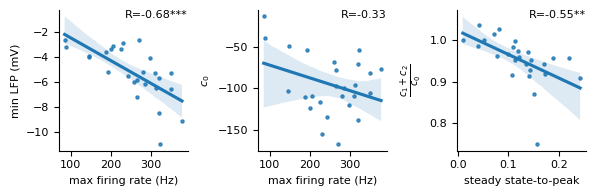

In [11]:
scatter_kws = {
    's': 5
}

def plot_correlation(x, y, ax):
    sns.regplot(x=x, y=y, data=df, ax=ax, scatter_kws=scatter_kws)
    
    corr, pval = pearsonr(df[x], df[y])
    
    ax.text(1, 1, f'R={corr:.2f}{signif(pval)}',
         transform = ax.transAxes, ha='right', va='top')

def plot_correlations_all(axes):
    plot_correlation('kde_peak', 'lfp_peak', axes[0])
    plot_correlation('kde_peak', 'depol_coef', axes[1])
    plot_correlation('pss', 'adapt_coef', axes[2])

    axes[0].set_xlabel('max firing rate (Hz)')
    axes[0].set_ylabel(r'min LFP (mV)')

    axes[1].set_xlabel('max firing rate (Hz)')
    axes[1].set_ylabel(r'$c_0$')

    axes[2].set_xlabel('steady state-to-peak')
    axes[2].set_ylabel(r'$\frac{c_1+c_2}{c_0}$', fontsize=10)

    
fig, axes = plt.subplots(ncols=3, figsize=(6,2))
plot_correlations_all(axes)
fig.tight_layout()

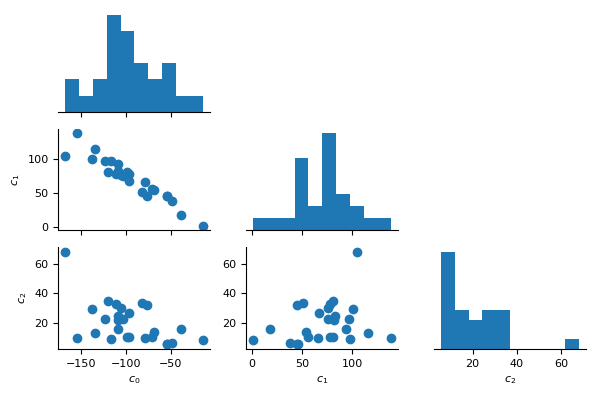

In [12]:
fig, axes = plt.subplots(ncols=3, nrows=3, sharex='col')

def plot_coefs_dependence(axes):
    coefs_arr = np.array(dicts[-1]['coefs_all'])
    for i in range(3):
        axes[i,i].hist(coefs_arr[:,i])
        despine_ax(axes[i,i], where='l')
        for j in range(i+1,3):
            axes[j,i].scatter(coefs_arr[:,i], coefs_arr[:,j])
            axes[i,j].remove()

    for i in range(3):
        axes[-1,i].set_xlabel(fr'$c_{{{i}}}$')
        if i > 0:
            axes[i,0].set_ylabel(fr'$c_{{{i}}}$')

plot_coefs_dependence(axes)
            
fig.tight_layout()
# plt.savefig('img/filter_param_distribution.png')

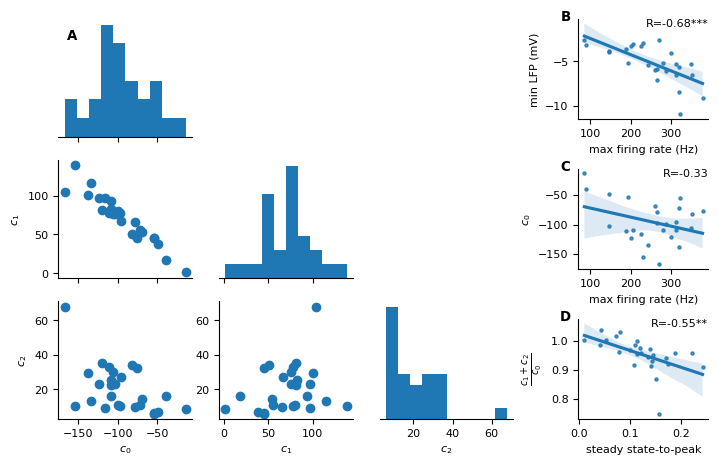

In [13]:
fig = plt.figure(figsize=(6.5, 4))

gs_square = fig.add_gridspec(3,3, top=1, bottom=0., left=0, right=0.7)

axes = np.empty(shape=(3,3), dtype=object)

for row in range(3):
    for col in range(3):
        axes[row,col] = fig.add_subplot(gs_square[row,col])
        
plot_coefs_dependence(axes)
axes[0,0].set_title('A', fontweight='bold', x=0.1, y=0.75)

for ax in [axes[0,0], axes[1,0], axes[1,1]]:
    ax.set_xticklabels([])


gs_col = fig.add_gridspec(3,1, top=1, bottom=0., left=0.8, right=1, hspace=0.5)

axes = np.array([fig.add_subplot(gs_col[i]) for i in range(3)])
plot_correlations_all(axes)

for ax, l in zip(axes, ['B','C','D']):
    ax.set_title(l, fontweight='bold', x=-0.1, y=0.9)